In [1]:
%pip install pyalex
%pip install scikit-learn


In [29]:
from pyalex import Works, Authors, Sources, Institutions,Topics, Concepts, Funders
from matplotlib.ticker import MaxNLocator
import pyalex,pandas as pd, numpy as np, matplotlib.pyplot as plt
import random,time,itertools
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import re
import requests
from google.colab import drive
drive.mount('/content/drive')
flatten = lambda x: list(itertools.chain.from_iterable(x))
from pyalex import config

config.max_retries = 3  # 最大再試行数を 3 回に設定
config.retry_backoff_factor = 1  # 再試行間隔を 0.1 秒に設定
config.retry_http_codes = [429, 500, 503]  # 再試行を行う HTTP エラーコードを指定




pyalex.config.email = "your_e_mail_adress" # ここにあなたのメールアドレスを入力してください

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
def fetch_all_results(url):
    url += "&per-page=200"
    results = []

    # リトライ回数
    retries = 3

    for _ in range(retries):
        try:
            # 初回のリクエストでカーソルを取得
            response = requests.get(url + "&cursor=*")
            data = response.json()

            # レスポンスから結果を取得
            if "results" in data:
                results += data["results"]

            # ページング情報を更新
            while "meta" in data and "next_cursor" in data["meta"]:
                next_cursor = data["meta"]["next_cursor"]
                response = requests.get(url + f"&cursor={next_cursor}")
                data = response.json()

                # レスポンスから結果を取得
                if "results" in data:
                    results += data["results"]

            # エラーが起きなかった場合はループを抜ける
            break
        except Exception as e:
            print(f"エラーが発生しました: {e}")
            print("リトライします...")
            time.sleep(5)
            continue

    return results




# GuilleminとSchallyの総論文数

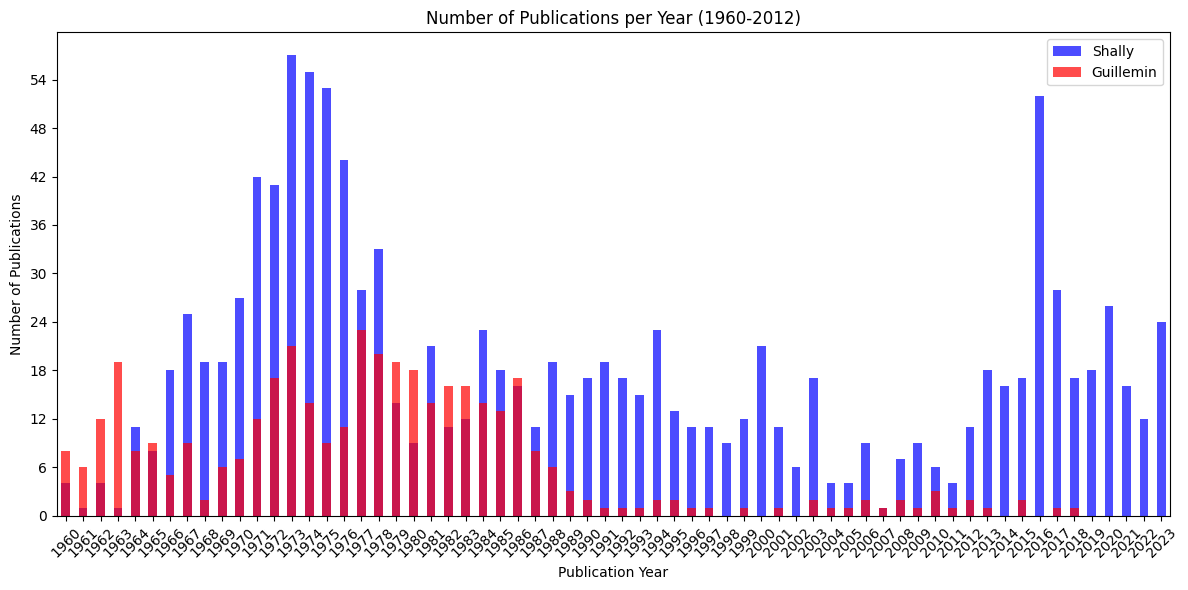

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


# データフレームのリストを作成する関数
def create_dataframe(data):
    cols = ["id","doi","title", "publication_year", "referenced_works", "cited_by_count", "abstract_inverted_index"]
    df_list = []
    for i in data:
        row = [i[col] for col in cols]
        df_list.append(row)
    return pd.DataFrame(df_list, columns=cols)

# 出版年ごとの出版数をカウントする関数
def count_publications(df):
    years = pd.Series(range(1960, 2024))
    publication_counts = df.groupby('publication_year').size()
    return publication_counts.reindex(years, fill_value=0)

# shally のデータを処理
url_shally = "https://api.openalex.org/works?page=1&filter=authorships.author.id:a5068739269,publication_year:%3C2024"
shally_data = fetch_all_results(url_shally)

# gu のデータを処理
url_gu = "https://api.openalex.org/works?page=1&filter=authorships.author.id:a5061993952,publication_year:%3C2024"
gu_data = fetch_all_results(url_gu)

# shally のデータフレームを作成
shally_df = create_dataframe(shally_data)

# gu のデータフレームを作成
gu_df = create_dataframe(gu_data)


# shally と gu の出版数をカウント
shally_publication_counts = count_publications(shally_df)
gu_publication_counts = count_publications(gu_df)

# プロットを作成
plt.figure(figsize=(12, 6))

# shally のプロット
ax = shally_publication_counts.plot(kind='bar', color='blue', alpha=0.7, label='Shally')

# gu のプロット
gu_publication_counts.plot(kind='bar', color='red', alpha=0.7, label='Guillemin', ax=ax)

plt.title('Number of Publications per Year (1960-2012)')
plt.xlabel('Publication Year')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()

plt.tight_layout()
plt.show()


# GuilleminがSchallyを引用した数、SchallyがGuilleminを引用した数

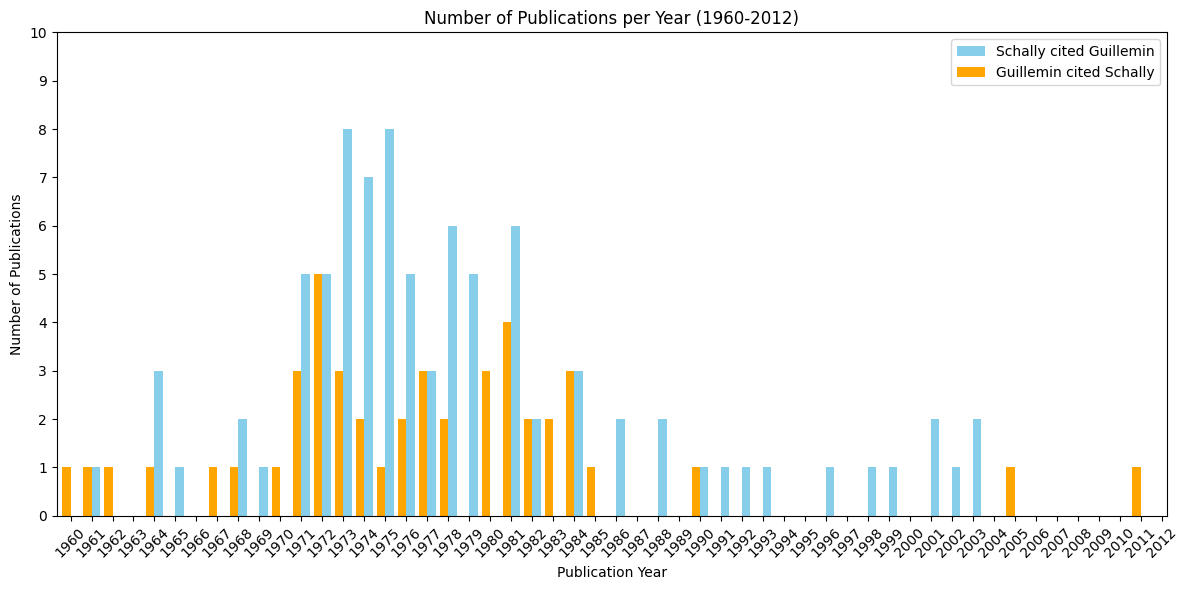

In [69]:
i


# 列名
cols = ["id","doi","title", "publication_year", "referenced_works", "cited_by_count", "abstract_inverted_index"]
gu_url = "https://api.openalex.org/works?page=1&filter=authorships.author.id:a5061993952,publication_year:%3C2024,referenced_works_count:%3E0"
sh_url = "https://api.openalex.org/works?page=1&filter=authorships.author.id:a5068739269,publication_year:%3C2024,referenced_works_count:%3E0"

def make_dataframe(url, cols):
    df = fetch_all_results(url)
    df_list = []
    # APIから取得したデータのリストをイテレート
    for i in df:
      row = [i[col] for col in cols]  # 各行のデータを取得
      df_list.append(row)  # リストに追加
    # データフレームを作成
    res_df = pd.DataFrame(df_list, columns=cols)

    return res_df



sh_df = make_dataframe(sh_url, cols)
gu_df = make_dataframe(gu_url, cols)





# SchallyがGuを引用している行を抽出
mask_sh = sh_df['referenced_works'].apply(lambda refs: any(id in refs for id in gu_df['id']))
ref_sh_df = sh_df[mask_sh]

# GuがSchallyを引用している行を抽出
mask_gu = gu_df['referenced_works'].apply(lambda refs: any(id in refs for id in sh_df['id']))
ref_gu_df = gu_df[mask_gu]

# 1960年から2012年までの範囲を作成
years = pd.Series(range(1960, 2013))

# SchallyがGuを引用している論文数のカウント
publication_counts_sh = ref_sh_df.groupby('publication_year').size()
publication_counts_sh = publication_counts_sh.reindex(years, fill_value=0)

# GuがSchallyを引用している論文数のカウント
publication_counts_gu = ref_gu_df.groupby('publication_year').size()
publication_counts_gu = publication_counts_gu.reindex(years, fill_value=0)

# プロットを作成
plt.figure(figsize=(12, 6))

# SchallyがGuを引用している論文数のプロット
ax = publication_counts_sh.plot(kind='bar', color='skyblue', position=0, width=0.4, label='Schally cited Guillemin')

# GuがSchallyを引用している論文数のプロット
publication_counts_gu.plot(kind='bar', color='orange', position=1, width=0.4, label='Guillemin cited Schally', ax=ax)

plt.title('Number of Publications per Year (1960-2012)')
plt.xlabel('Publication Year')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)

# y軸を整数値のみ表示するように設定し、範囲を0から5に固定
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylim(0, 10)

plt.legend()
plt.tight_layout()

# プロットを表示
plt.show()


# SchallyがGuilleminを引用した論文のDOI

In [72]:
ref_sh_df[ref_sh_df["publication_year"]<1971]["doi"].to_list()

['https://doi.org/10.1016/s0021-9258(17)36387-1',
 'https://doi.org/10.1016/b978-1-4831-9827-9.50016-2',
 'https://doi.org/10.1042/bj0700097',
 'https://doi.org/10.1016/s0026-0495(64)80036-6',
 'https://doi.org/10.1016/s0021-9258(18)91386-4',
 'https://doi.org/10.1038/207978a0',
 'https://doi.org/10.1016/0003-9861(64)90339-x',
 'https://doi.org/10.1007/bf01243953',
 'https://doi.org/10.1016/0005-2795(68)90023-8']

#1 文内引用有


*   Adsorption on charcoal was carried out essentially by the method of Guillemin et al. (8)

*   The R¹ of TRH was approximately 0.2, in agreement with the observations of Burgus and Guillemin (41) on ovine TRH. This lack of significant purification on the second partition system may be due to the fact that the same solvent system was used for counter- current distribution.
* In addition, this TRH released 1311 from thyroid glands of rats (1), prepared as described by Yamazaki, Sakiz, and Guillemin (42), depleted pituitary TSH content in mice (1, 39) and in- creased incorporation of 14C amino acids into the rat pituitary tissue (1). This material was purified about 570,000 times, like TRH Preparation I (Table V).
* In their latest report Burgus and Guillemin (41) revised their initial view and re-
ported that ovine TRH contains 62 to 79% amino acid material
with proline, glutamic acid, and histidine occurring in a molar
ratio of 1:1:1 (41). A direct comparison of the potency of
ovine TRH preparations and our porcine TRH was not carried
out, but, since similar assays were utilized for assaying ovine and
porcine TRH preparation, it appears that our preparation of
porcine TRH may be 10 to 15 times more potent (7) than the
ovine TRH of Guillemin et al. (8, 41). It may be of interest to
report that the following eight tripeptides synthesized by Merck
Sharp and Dohme were inactive in vivo in 10-µg doses









2. 共著

3. 共著

4. 参考文献のみ

5. 共著

6. 参考文献のみ

7. 参考文献のみ

8. 共著

9. 参考文献のみ




# GuilleminがSchallyを引用した論文のDOI

In [73]:
ref_gu_df[ref_gu_df["publication_year"]<1971]["doi"].to_list()

['https://doi.org/10.1038/226321a0',
 'https://doi.org/10.1038/1881192a0',
 'https://doi.org/10.1016/s0021-9258(18)91386-4',
 'https://doi.org/10.1007/bf00260140',
 'https://doi.org/10.1007/bf02142149',
 'https://doi.org/10.1007/bf01243953',
 'https://doi.org/10.1007/978-1-4614-4612-5_19']

#1文内引用有
* Other fragments, m/e 234, 235 and 249, could arise from PCA-His, His-Pro-NH, or also, as Schally et al. mentioned in the case of a preparation of porcino TRF, from the diketopiperazines of histidine and proline


* Recently, Folkers et al.1s and Bowers et al. (paper prosentedat a meeting of the American Thyroid Association, Chicago, November 1969) have confirmed that mixtures of synthetic peptides obtained by ammonolysis of the esterified derivatives of the sequence Glu-His-Pro have considerable TRF activity, in agreement with our earlier reports


2. 共著
3. 共著
4. 参考文献のみ
5. 参考文献のみ
6. 共著


#7 文内引用あり
The molecule of TRF may contain 3 amino acids, as we still find after 6N HC1 hydrolysis of a highly purified preparation of TRF, proline, histidine and glutamic acid. The quantities and by the way, molar ratios do not quite agree with what was reported by Schally et al. (19,20) but I certainly would not want to make a statement at this moment as to who is right and who is wrong.